**<center><font size=5>Brain Tumor Detection with VGG-16 Model</font></center>**
***
**author**: 

**date**: 25th January, 2024

**Table of Contents**
- <a href='#intro'>1. Project Overview and Objectives</a> 
    - <a href='#dataset'>1.1. Data Set Description</a>
    - <a href='#tumor'>1.2. What is Brain Tumor?</a>
- <a href='#env'>2. Setting up the Environment</a>
- <a href='#import'>3. Data Import and Preprocessing</a>
- <a href='#cnn'>4. CNN Model</a>
    - <a href='#aug'>4.1. Data Augmentation</a>
        - <a href='#demo'>4.1.1. Demo</a>
        - <a href='#apply'>4.1.2. Apply</a>
    - <a href='#build'>4.2. Model Building</a>
    - <a href='#perf'>4.3. Model Performance</a>
- <a href='#concl'>5. Conclusions</a>

# <a id='intro'>1. Project Overview and Objectives</a>

The main purpose of this project was to build a CNN model that would classify if subject has a tumor or not base on MRI scan. I used the [VGG-16](https://www.kaggle.com/navoneel/brain-mri-images-for-brain-tumor-detection) model architecture and weights to train the model for this binary problem. I used `accuracy` as a metric to justify the model performance which can be defined as:

$\textrm{Accuracy} = \frac{\textrm{Number of correclty predicted images}}{\textrm{Total number of tested images}} \times 100\%$

Final results look as follows:

| Set | Accuracy |
|:-:|:-:|
| Validation Set* | ~88% |
| Test Set* | ~80% |
<br>
\* *Note: there might be some misunderstanding in terms of set names so I want to describe what do I mean by `test` and `validation` set:*
* *`validation set` - is the set used during the model training to adjust the hyperparameters. *
* *`test set` - is the small set that I don't touch for the whole training process at all. It's been used for final model performance evaluation.*

## <a id='dataset'>1.1. Data Set Description</a>

The image data that was used for this problem is [Brain MRI Images for Brain Tumor Detection](https://www.kaggle.com/navoneel/brain-mri-images-for-brain-tumor-detection). It conists of MRI scans of two classes:

* `NO` - no tumor, encoded as `0`
* `YES` - tumor, encoded as `1`

Unfortunately, the data set description doesn't hold any information where this MRI scans come from and so on.

## <a id='tumor'>1.2. What is Brain Tumor?</a>

> A brain tumor occurs when abnormal cells form within the brain. There are two main types of tumors: cancerous (malignant) tumors and benign tumors. Cancerous tumors can be divided into primary tumors, which start within the brain, and secondary tumors, which have spread from elsewhere, known as brain metastasis tumors. All types of brain tumors may produce symptoms that vary depending on the part of the brain involved. These symptoms may include headaches, seizures, problems with vision, vomiting and mental changes. The headache is classically worse in the morning and goes away with vomiting. Other symptoms may include difficulty walking, speaking or with sensations. As the disease progresses, unconsciousness may occur.
>
> ![](https://upload.wikimedia.org/wikipedia/commons/5/5f/Hirnmetastase_MRT-T1_KM.jpg)
>
> *Brain metastasis in the right cerebral hemisphere from lung cancer, shown on magnetic resonance imaging.*

Source: [Wikipedia](https://en.wikipedia.org/wiki/Brain_tumor)

# <a id='env'>2. Setting up the Environment</a>

In [1]:
import numpy as np 
from tqdm import tqdm
import cv2
import os
import shutil
import itertools
import imutils
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras import layers
from keras.models import Model, Sequential
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping

init_notebook_mode(connected=True)
RANDOM_SEED = 123

Right now all images are in one folder with `yes` and `no` subfolders. I will split the data into `train`, `val` and `test` folders which makes its easier to work for me. The new folder heirarchy will look as follows:

In [2]:
!apt-get install tree
# create new folders
!mkdir TRAIN TEST VAL TRAIN/YES TRAIN/NO TEST/YES TEST/NO VAL/YES VAL/NO
!tree -d

'apt-get' is not recognized as an internal or external command,
operable program or batch file.
The syntax of the command is incorrect.


Folder PATH listing
Volume serial number is 000000CD 040F:7EAC
C:\USERS\HP\DOCUMENTS\GITHUB\PROJECT-SEM4\PYTHON MODELS\BRAIN DATA\-D
Invalid path - \USERS\HP\DOCUMENTS\GITHUB\PROJECT-SEM4\PYTHON MODELS\BRAIN DATA\-D
No subfolders exist 



In [3]:
IMG_PATH = r'C:\Users\HP\Documents\GitHub\Project-Sem4\Python Models\Brain Data\Brain_tumor_dataset'

# split the data by train/val/test
for CLASS in os.listdir(IMG_PATH):
    if not CLASS.startswith('.'):
        class_path = os.path.join(IMG_PATH, CLASS)  # Use os.path.join to ensure correct path concatenation
        IMG_NUM = len(os.listdir(class_path))

        for (n, FILE_NAME) in enumerate(os.listdir(class_path)):
            img = os.path.join(class_path, FILE_NAME)  # Use os.path.join to ensure correct path concatenation

            # Create target directories if they don't exist
            target_dir_test = os.path.join('TEST', CLASS.upper())
            target_dir_train = os.path.join('TRAIN', CLASS.upper())
            target_dir_val = os.path.join('VAL', CLASS.upper())

            os.makedirs(target_dir_test, exist_ok=True)
            os.makedirs(target_dir_train, exist_ok=True)
            os.makedirs(target_dir_val, exist_ok=True)

            if n < 5:
                shutil.copy(img, os.path.join(target_dir_test, FILE_NAME))
            elif n < 0.8 * IMG_NUM:
                shutil.copy(img, os.path.join(target_dir_train, FILE_NAME))
            else:
                shutil.copy(img, os.path.join(target_dir_val, FILE_NAME))


# <a id='import'>3. Data Import and Preprocessing</a>

In [4]:
def load_data(dir_path, img_size=(100,100)):
    """
    Load resized images as np.arrays to workspace
    """
    X = []
    y = []
    i = 0
    labels = dict()
    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            labels[i] = path
            for file in os.listdir(dir_path + path):
                if not file.startswith('.'):
                    img = cv2.imread(dir_path + path + '/' + file)
                    X.append(img)
                    y.append(i)
            i += 1
    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y, labels



def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [5]:
def load_data(directory, img_size):
    X = []
    y = []
    labels = []

    for label in os.listdir(directory):
        label_path = os.path.join(directory, label)
        if os.path.isdir(label_path) and not label.startswith('.'):
            labels.append(label)
            for file in os.listdir(label_path):
                if not file.startswith('.'):
                    img_path = os.path.join(label_path, file)
                    img = cv2.imread(img_path)
                    img = cv2.resize(img, img_size)
                    X.append(img)
                    y.append(labels.index(label))  # Assuming labels are numerical indices

    return np.array(X), np.array(y), labels

# Your directory paths
TRAIN_DIR = r'C:\Users\HP\Documents\GitHub\Project-Sem4\Python Models\Brain Data\TRAIN'
TEST_DIR = r'C:\Users\HP\Documents\GitHub\Project-Sem4\Python Models\Brain Data\TEST'
VAL_DIR = r'C:\Users\HP\Documents\GitHub\Project-Sem4\Python Models\Brain Data\VAL'
IMG_SIZE = (224, 224)

# use predefined function to load the image data into workspace
X_train, y_train, labels = load_data(TRAIN_DIR, IMG_SIZE)
X_test, y_test, _ = load_data(TEST_DIR, IMG_SIZE)
X_val, y_val, _ = load_data(VAL_DIR, IMG_SIZE)


Let's take a look at the distribution of classes among sets:

In [6]:
y = dict()
y[0] = []
y[1] = []
for set_name in (y_train, y_val, y_test):
    y[0].append(np.sum(set_name == 0))
    y[1].append(np.sum(set_name == 1))

trace0 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[0],
    name='No',
    marker=dict(color='#33cc33'),
    opacity=0.7
)
trace1 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[1],
    name='Yes',
    marker=dict(color='#ff3300'),
    opacity=0.7
)
data = [trace0, trace1]
layout = go.Layout(
    title='Count of classes in each set',
    xaxis={'title': 'Set'},
    yaxis={'title': 'Count'}
)
fig = go.Figure(data, layout)
iplot(fig)

In [7]:
def plot_samples(X, y, labels_dict, n=50):
    """
    Creates a gridplot for desired number of images (n) from the specified set
    """
    for index in range(len(labels_dict)):
        imgs = X[np.argwhere(y == index)][:n]
        j = 10
        i = int(n/j)

        plt.figure(figsize=(15,6))
        c = 1
        for img in imgs:
            plt.subplot(i,j,c)
            plt.imshow(img[0])

            plt.xticks([])
            plt.yticks([])
            c += 1
        plt.suptitle('Tumor: {}'.format(labels_dict[index]))
        plt.show()

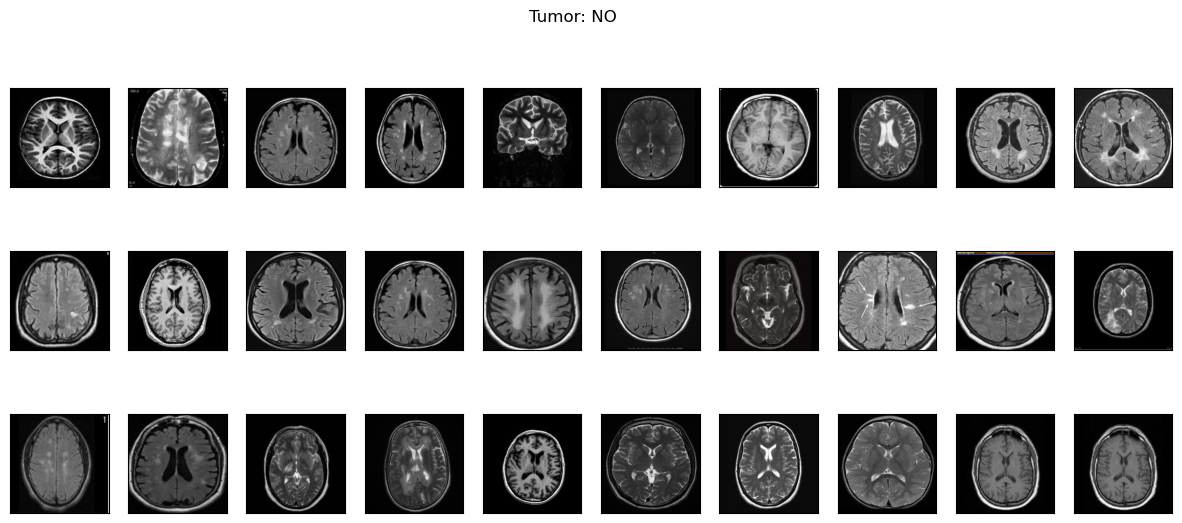

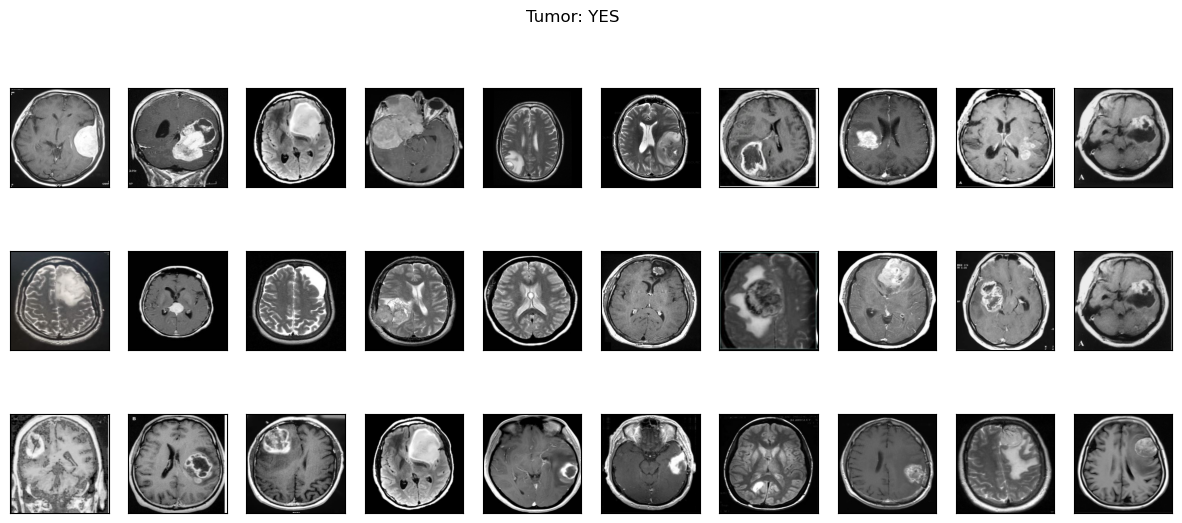

In [8]:
plot_samples(X_train, y_train, labels, 30)

As you can see, images have different `width` and `height` and diffent size of "black corners". Since the image size for VGG-16 imput layer is `(224,224)` some wide images may look weird after resizing. Histogram of ratio distributions (`ratio = width/height`):

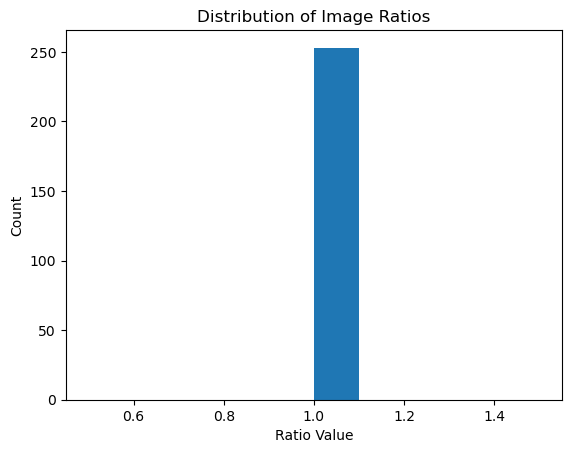

In [9]:
RATIO_LIST = []
for set in (X_train, X_test, X_val):
    for img in set:
        RATIO_LIST.append(img.shape[1]/img.shape[0])
        
plt.hist(RATIO_LIST)
plt.title('Distribution of Image Ratios')
plt.xlabel('Ratio Value')
plt.ylabel('Count')
plt.show()

The first step of "normalization" would be to crop the brain out of the images. I used technique which was perfectly described in [pyimagesearch](https://www.pyimagesearch.com/2016/04/11/finding-extreme-points-in-contours-with-opencv/) blog and I highly suggest to looks deeper into it.

In [10]:
import cv2
import imutils
import numpy as np

def crop_imgs(set_name, add_pixels_value=0, target_size=(100, 100)):
    """
    Finds the extreme points on the image, crops the rectangular region, and resizes to a target size.
    """
    set_new = []
    for img in set_name:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        gray = cv2.GaussianBlur(gray, (5, 5), 0)

        # threshold the image, then perform a series of erosions +
        # dilations to remove any small regions of noise
        thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)

        # find contours in thresholded image, then grab the largest one
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        c = max(cnts, key=cv2.contourArea)

        # find the extreme points
        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])

        ADD_PIXELS = add_pixels_value
        new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()

        # Resize the cropped image to the target size
        new_img_resized = cv2.resize(new_img, target_size)

        set_new.append(new_img_resized)

    return np.array(set_new)

Let's look at example what this function will do with MRI scans:

In [11]:
img = cv2.imread(r'C:\Users\HP\Documents\GitHub\Project-Sem4\Python Models\Brain Data\Brain_tumor_dataset\yes\Y108.jpg')
img = cv2.resize(
            img,
            dsize=IMG_SIZE,
            interpolation=cv2.INTER_CUBIC
        )
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)

# threshold the image, then perform a series of erosions +
# dilations to remove any small regions of noise
thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
thresh = cv2.erode(thresh, None, iterations=2)
thresh = cv2.dilate(thresh, None, iterations=2)

# find contours in thresholded image, then grab the largest one
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
c = max(cnts, key=cv2.contourArea)

# find the extreme points
extLeft = tuple(c[c[:, :, 0].argmin()][0])
extRight = tuple(c[c[:, :, 0].argmax()][0])
extTop = tuple(c[c[:, :, 1].argmin()][0])
extBot = tuple(c[c[:, :, 1].argmax()][0])

# add contour on the image
img_cnt = cv2.drawContours(img.copy(), [c], -1, (0, 255, 255), 4)

# add extreme points
img_pnt = cv2.circle(img_cnt.copy(), extLeft, 8, (0, 0, 255), -1)
img_pnt = cv2.circle(img_pnt, extRight, 8, (0, 255, 0), -1)
img_pnt = cv2.circle(img_pnt, extTop, 8, (255, 0, 0), -1)
img_pnt = cv2.circle(img_pnt, extBot, 8, (255, 255, 0), -1)

# crop
ADD_PIXELS = 0
new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()

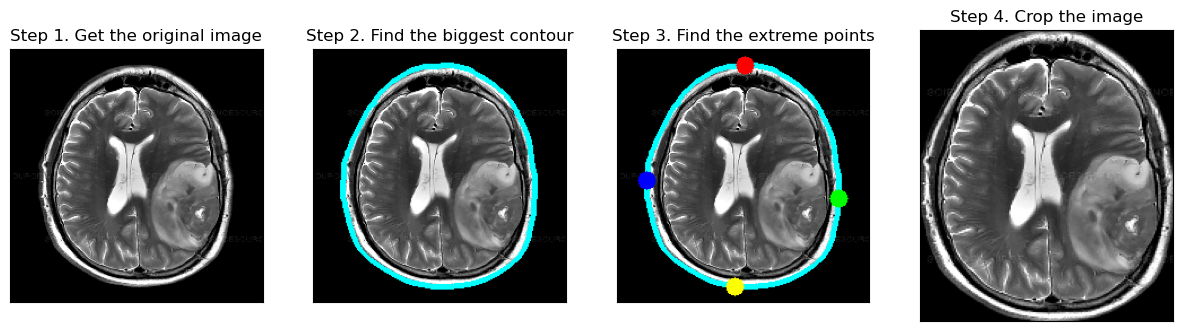

In [12]:
plt.figure(figsize=(15,6))
plt.subplot(141)
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.title('Step 1. Get the original image')
plt.subplot(142)
plt.imshow(img_cnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 2. Find the biggest contour')
plt.subplot(143)
plt.imshow(img_pnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 3. Find the extreme points')
plt.subplot(144)
plt.imshow(new_img)
plt.xticks([])
plt.yticks([])
plt.title('Step 4. Crop the image')
plt.show()

In [13]:
X_train_crop = crop_imgs(set_name=X_train)
X_val_crop = crop_imgs(set_name=X_val)
X_test_crop = crop_imgs(set_name=X_test)

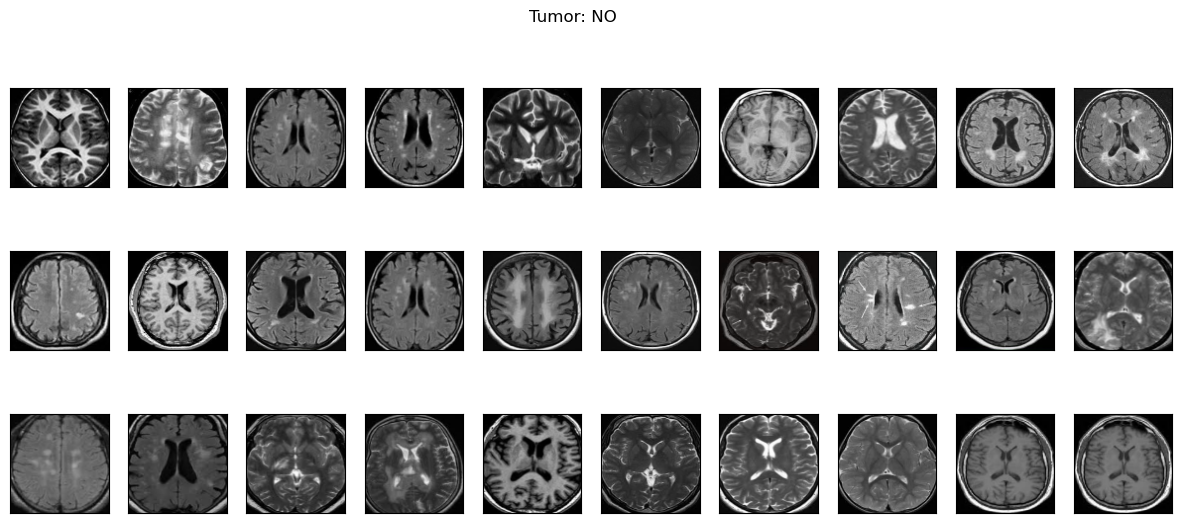

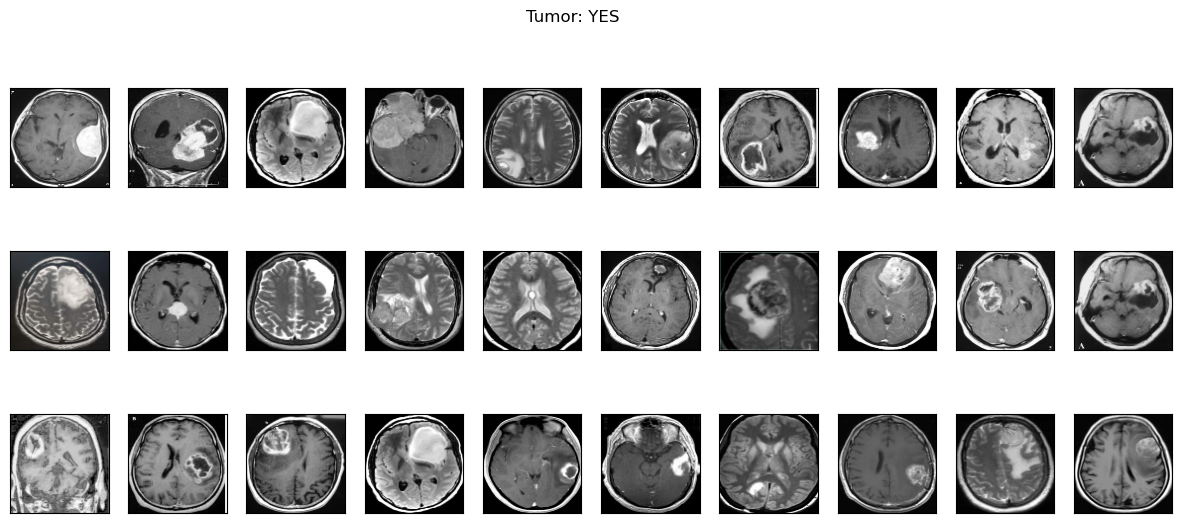

In [14]:
plot_samples(X_train_crop, y_train, labels, 30)

In [15]:
def save_new_images(x_set, y_set, folder_name):
    i = 0
    for (img, imclass) in zip(x_set, y_set):
        if imclass == 0:
            cv2.imwrite(folder_name+'NO/'+str(i)+'.jpg', img)
        else:
            cv2.imwrite(folder_name+'YES/'+str(i)+'.jpg', img)
        i += 1

In [16]:
# saving new images to the folder
!mkdir TRAIN_CROP TEST_CROP VAL_CROP TRAIN_CROP/YES TRAIN_CROP/NO TEST_CROP/YES TEST_CROP/NO VAL_CROP/YES VAL_CROP/NO

save_new_images(X_train_crop, y_train, folder_name='TRAIN_CROP/')
save_new_images(X_val_crop, y_val, folder_name='VAL_CROP/')
save_new_images(X_test_crop, y_test, folder_name='TEST_CROP/')

The syntax of the command is incorrect.


The next step would be resizing images to `(224,224)` and applying preprocessing needed for VGG-16 model input.

In [17]:
def preprocess_imgs(set_name, img_size):
    """
    Resize and apply VGG-15 preprocessing
    """
    set_new = []
    for img in set_name:
        img = cv2.resize(
            img,
            dsize=img_size,
            interpolation=cv2.INTER_CUBIC
        )
        set_new.append(preprocess_input(img))
    return np.array(set_new)

In [18]:
X_train_prep = preprocess_imgs(set_name=X_train_crop, img_size=IMG_SIZE)
X_test_prep = preprocess_imgs(set_name=X_test_crop, img_size=IMG_SIZE)
X_val_prep = preprocess_imgs(set_name=X_val_crop, img_size=IMG_SIZE)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

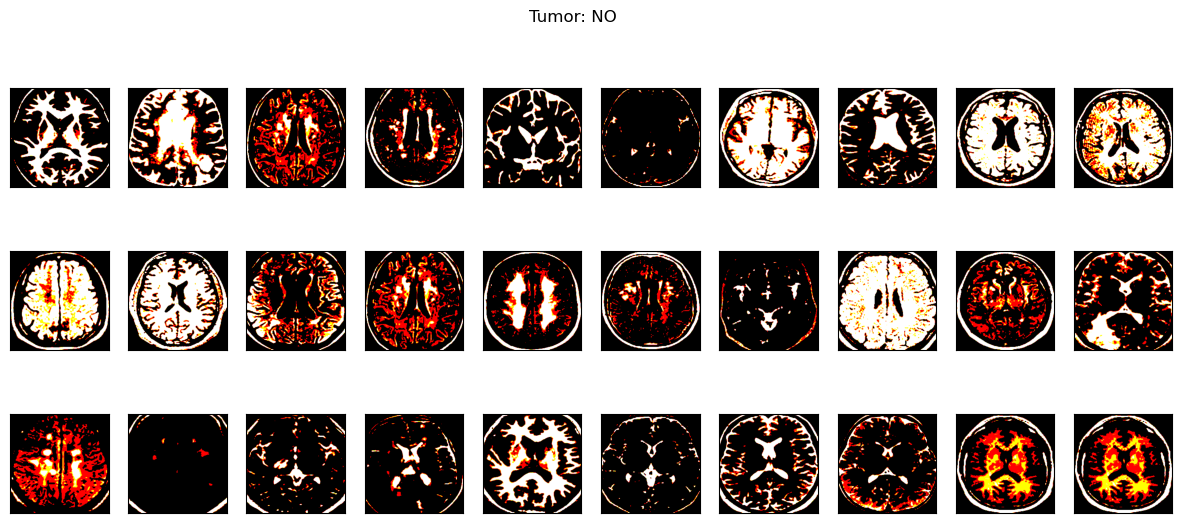

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

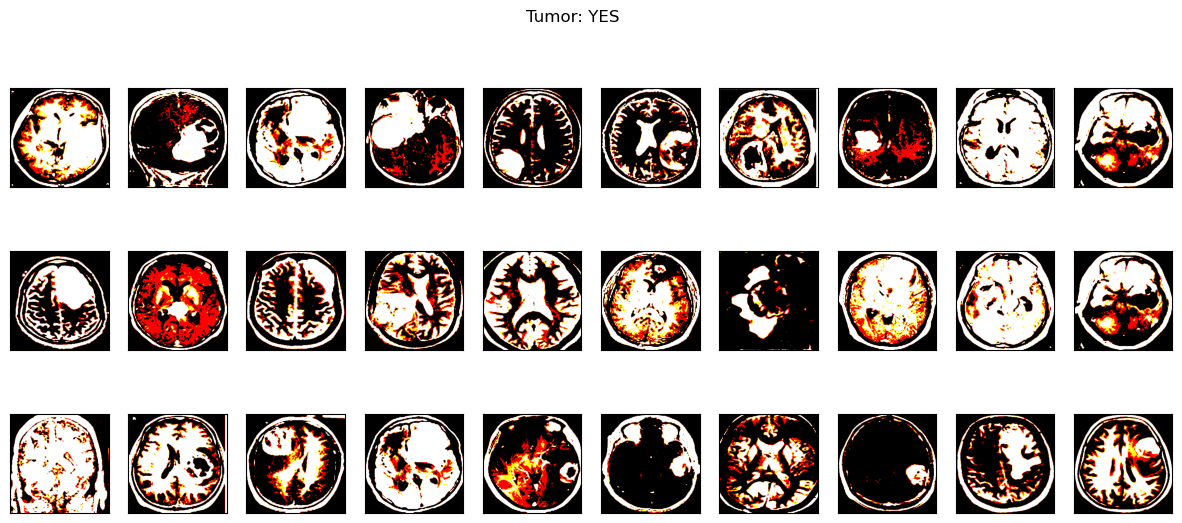

In [19]:
plot_samples(X_train_prep, y_train, labels, 30)

# <a id='cnn'>4. CNN Model</a>

I was using [Transfer Learning](https://towardsdatascience.com/keras-transfer-learning-for-beginners-6c9b8b7143e) with VGG-16 architecture and weights as a base model.

## <a id='aug'>4.1. Data Augmentation</a>

Since I had small data set I used the technique called [Data Augmentation](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html) which helps to "increase" the size of training set.

### <a id='demo'>4.1.1. Demo</a>

That's the example from one image how does augmentation look like.

In [20]:
# set the paramters we want to change randomly
demo_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.05,
    height_shift_range=0.05,
    rescale=1./255,
    shear_range=0.05,
    brightness_range=[0.1, 1.5],
    horizontal_flip=True,
    vertical_flip=True
)

In [21]:
os.mkdir('preview')
x = X_train_crop[0]  
x = x.reshape((1,) + x.shape) 

i = 0
for batch in demo_datagen.flow(x, batch_size=1, save_to_dir='preview', save_prefix='aug_img', save_format='jpg'):
    i += 1
    if i > 20:
        break 

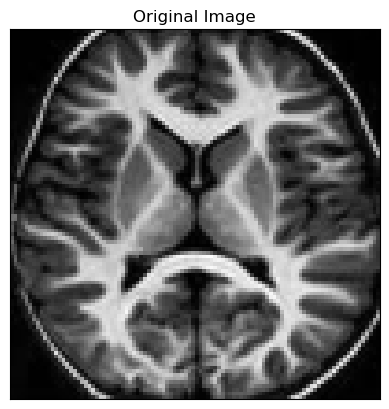

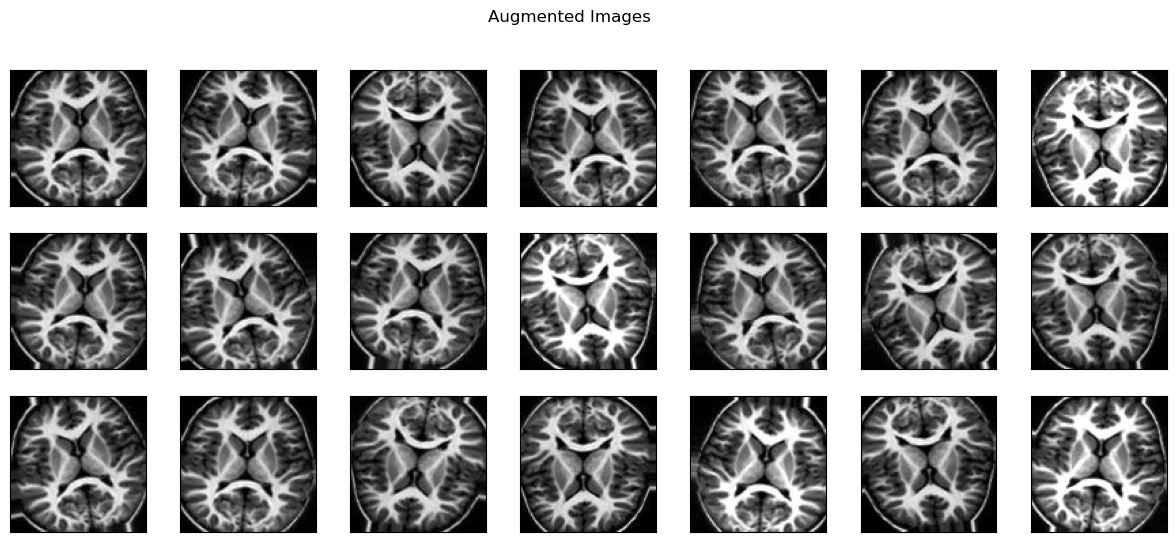

In [22]:
plt.imshow(X_train_crop[0])
plt.xticks([])
plt.yticks([])
plt.title('Original Image')
plt.show()

plt.figure(figsize=(15, 6))
i = 1
for img_file in os.listdir('preview/'):
    img = cv2.imread('preview/' + img_file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(3, 7, i)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    i += 1
    if i > 3 * 7:
        break
plt.suptitle('Augmented Images')
plt.show()


In [23]:
import shutil

shutil.rmtree('preview/')

### <a id='apply'>4.1.2. Apply</a>

In [24]:
TRAIN_DIR = r'C:\Users\HP\Documents\GitHub\Project-Sem4\Python Models\Brain Data\TRAIN'
VAL_DIR = r'C:\Users\HP\Documents\GitHub\Project-Sem4\Python Models\Brain Data\VAL'

train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    brightness_range=[0.5, 1.5],
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)


train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='binary',
    seed=RANDOM_SEED
)


validation_generator = test_datagen.flow_from_directory(
    VAL_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=16,
    class_mode='binary',
    seed=RANDOM_SEED
)

Found 193 images belonging to 2 classes.
Found 50 images belonging to 2 classes.


In [25]:
def get_class_distribution(generator):
    classes = generator.classes
    class_distribution = np.bincount(classes)
    total_samples = len(classes)
    class_distribution_percentage = class_distribution / total_samples * 100
    return class_distribution_percentage

# Get class distribution for each set
train_class_distribution = get_class_distribution(train_generator)
validation_class_distribution = get_class_distribution(validation_generator)
# test_class_distribution = get_class_distribution(test_generator)

# Display the class distribution
print("Train Class Distribution:", train_class_distribution)
print("Validation Class Distribution:", validation_class_distribution)
# print("Test Class Distribution:", test_class_distribution)

Train Class Distribution: [38.34196891 61.65803109]
Validation Class Distribution: [38. 62.]


## <a id='build'>4.2. Model Building</a>

In [28]:
base_model = VGG16(
    weights='imagenet',
    include_top=False, 
    input_shape=IMG_SIZE + (3,)
)

In [29]:
NUM_CLASSES = 1

model = Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(NUM_CLASSES, activation='sigmoid'))

model.layers[0].trainable = False

model.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(lr=1e-4),
    metrics=['accuracy']
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dropout (Dropout)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 1)                 25089     
                                                                 
Total params: 14739777 (56.23 MB)
Trainable params: 25089 (98.00 KB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [31]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Create a new model on top of the VGG16 base model
model_new = models.Sequential()

# Add the VGG16 base model
model_new.add(base_model)

# Flatten the output of the VGG16 base model
model_new.add(layers.Flatten())

# Add some dense layers for classification
model_new.add(layers.Dense(256, activation='relu'))
model_new.add(layers.Dropout(0.5))
model_new.add(layers.Dense(1, activation='sigmoid'))  # Assuming binary classification

# Compile the new model
model_new.compile(
    loss='binary_crossentropy',
    optimizer=optimizers.RMSprop(learning_rate=1e-4),  # You can adjust the learning rate
    metrics=['accuracy']
)

# Display the model summary to check the architecture
model_new.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_1 (Dense)             (None, 256)               6422784   
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 257       
                                                                 
Total params: 21137729 (80.63 MB)
Trainable params: 6423041 (24.50 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [32]:
EPOCHS = 30

# es = EarlyStopping(
#     monitor='val_accuracy',  # Change to 'val_accuracy'
#     mode='max',
#     patience=6
# )

history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    # callbacks=[es]
)

print("........ NEW MODEL ........")


history_new = model_new.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    # callbacks=[es]
)

Epoch 1/30



7/7 [==============================] - 31s 4s/step - loss: 12.6587 - accuracy: 0.6218 - val_loss: 2.8816 - val_accuracy: 0.7600
Epoch 2/30
7/7 [==============================] - 27s 4s/step - loss: 3.0519 - accuracy: 0.7668 - val_loss: 0.7164 - val_accuracy: 0.9000
Epoch 3/30
7/7 [==============================] - 27s 4s/step - loss: 3.3556 - accuracy: 0.7720 - val_loss: 0.8410 - val_accuracy: 0.9400
Epoch 4/30
7/7 [==============================] - 20s 3s/step - loss: 3.5177 - accuracy: 0.7513 - val_loss: 2.0078 - val_accuracy: 0.8600
Epoch 5/30
7/7 [==============================] - 21s 3s/step - loss: 2.5175 - accuracy: 0.8497 - val_loss: 0.7247 - val_accuracy: 0.9200
Epoch 6/30
7/7 [==============================] - 21s 3s/step - loss: 1.9404 - accuracy: 0.7824 - val_loss: 0.5571 - val_accuracy: 0.9400
Epoch 7/30
7/7 [==============================] - 21s 3s/step - loss: 2.4720 - accuracy: 0.8083 - val_loss: 0.5550 - val_accuracy: 0.9400
Epoch 8/30
7/7 [============================

In [34]:
# Predict accuracy using y test
# y_pred = model.predict_classes(X_test_prep)

# Assuming you have a test generator
test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=16,
    class_mode='binary',  # This assumes a binary classification problem
    seed=RANDOM_SEED
)

# Get the true class labels for the test set
y_true = test_generator.classes

y_pred = model.predict(X_test_prep)
y_pred = (y_pred > 0.5).astype(int)
accuracy = np.sum(y_pred.flatten() == y_true) / len(y_true)

y_pred_new = model_new.predict(X_test_prep)
y_pred_new = (y_pred_new > 0.5).astype(int)
accuracy_new = np.sum(y_pred_new.flatten() == y_true) / len(y_true)


print("Accuracy on Test Set:", accuracy)
print("Accuracy on Test Set:", accuracy_new)

Found 10 images belonging to 2 classes.


1/1 [==============================] - 1s 991ms/step
Accuracy on Test Set: 0.9
Accuracy on Test Set: 0.9


## <a id='perf'>4.3. Model Performance</a>

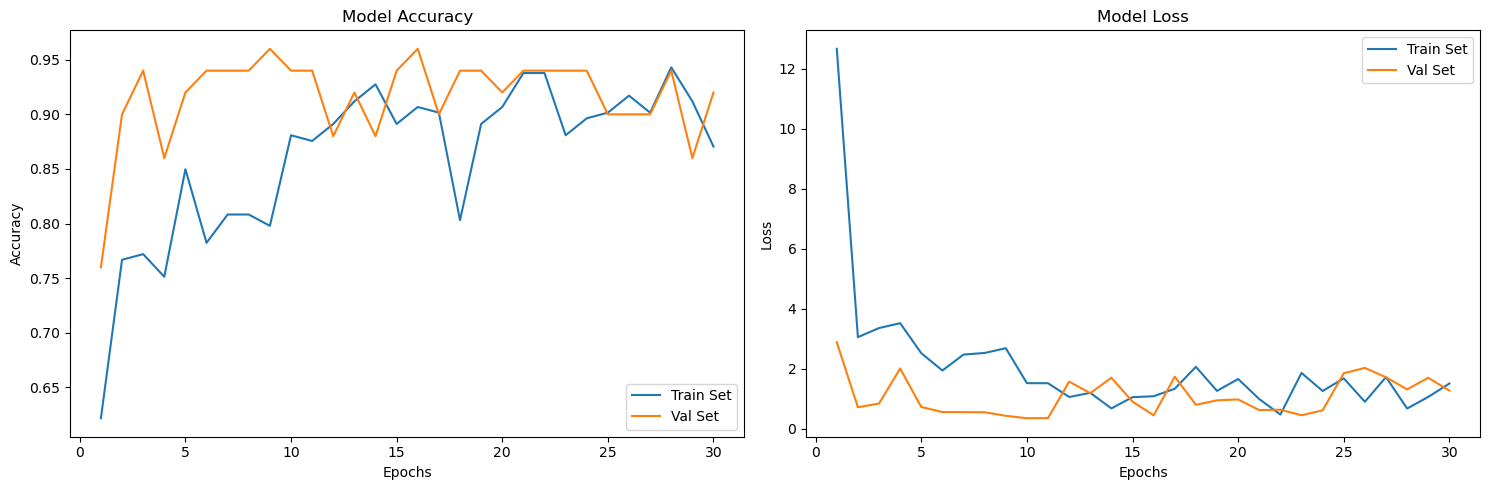

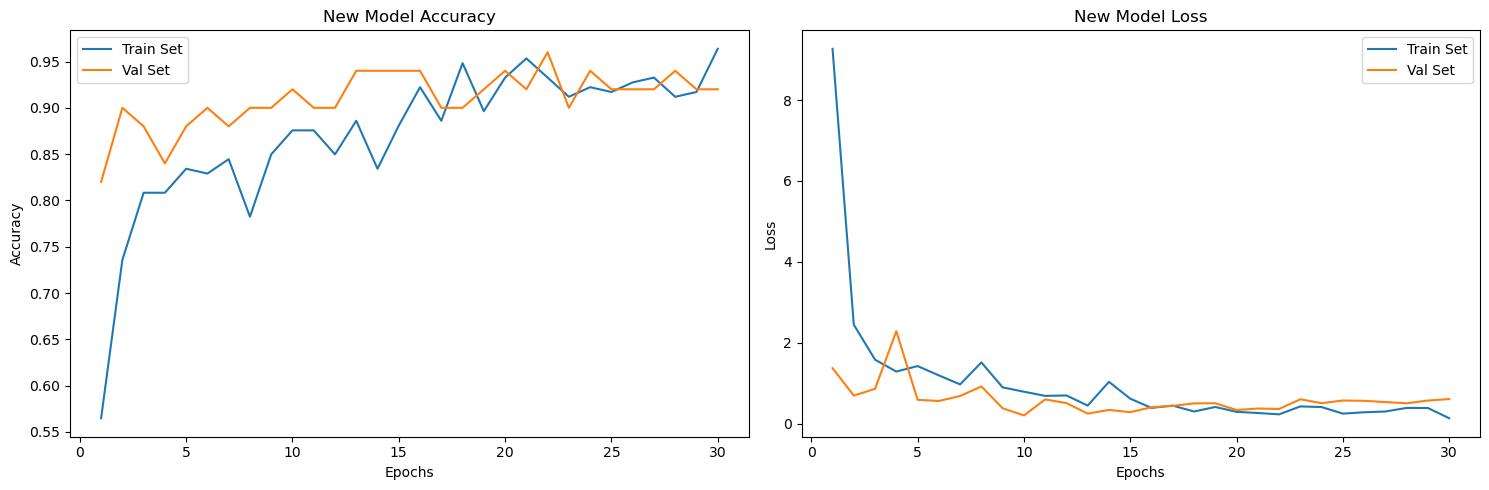

In [35]:
# plot model performance
accu = history.history['accuracy']  # Change from 'acc' to 'accuracy'
val_acc = history.history['val_accuracy']  # Change from 'val_acc' to 'val_accuracy'
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, accu, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()




# Plot model performance for the new model
accu_new = history_new.history['accuracy']
val_acc_new = history_new.history['val_accuracy']
loss_new = history_new.history['loss']
val_loss_new = history_new.history['val_loss']
epochs_range_new = range(1, len(history_new.epoch) + 1)

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range_new, accu_new, label='Train Set')
plt.plot(epochs_range_new, val_acc_new, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('New Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range_new, loss_new, label='Train Set')
plt.plot(epochs_range_new, val_loss_new, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('New Model Loss')

plt.tight_layout()
plt.show()

2/2 [==============================] - 4s 1s/step
Val Accuracy = 0.84


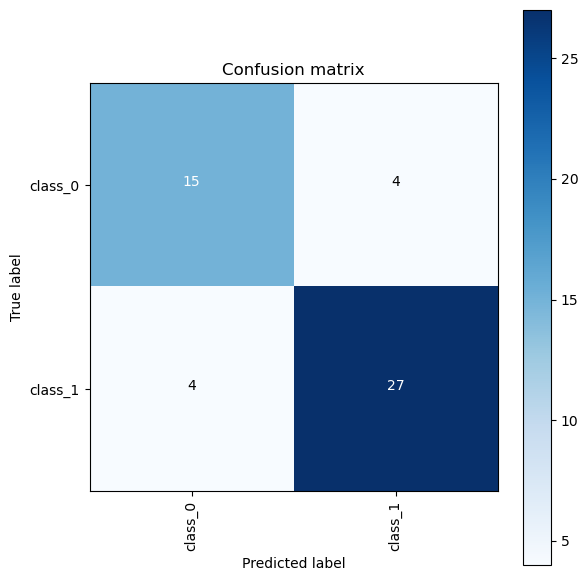

2/2 [==============================] - 4s 1s/step
New Model Val Accuracy = 0.82


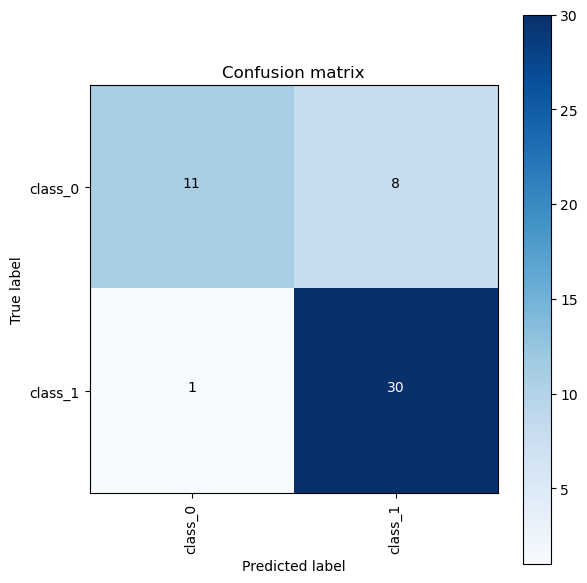

In [36]:
# Assuming labels is a dictionary
labels = {'class_0': 0, 'class_1': 1}  # Replace this with your actual labels


# First Model

# validate on val set
predictions = model.predict(X_val_prep)
predictions = [1 if x > 0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_val, predictions)
print('Val Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_val, predictions)

# Use list(labels.keys()) instead of list(labels.items())
cm = plot_confusion_matrix(confusion_mtx, classes=list(labels.keys()), normalize=False)


# Second Model

# Validate on validation set
predictions_new = model_new.predict(X_val_prep)
predictions_new = [1 if x > 0.5 else 0 for x in predictions_new]

accuracy_new = accuracy_score(y_val, predictions_new)
print('New Model Val Accuracy = %.2f' % accuracy_new)

confusion_mtx_new = confusion_matrix(y_val, predictions_new)

# Use list(labels.keys()) instead of list(labels.items())
cm_new = plot_confusion_matrix(confusion_mtx_new, classes=list(labels.keys()), normalize=False)

1/1 [==============================] - 1s 674ms/step
Test Accuracy = 0.90


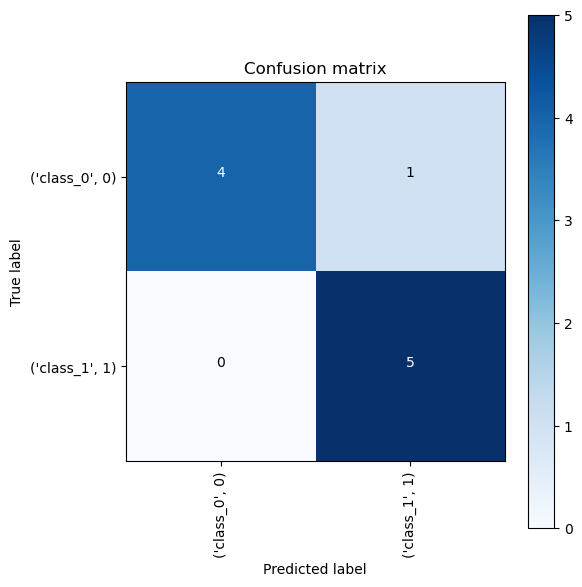

1/1 [==============================] - 1s 864ms/step
New Model Test Accuracy = 0.90


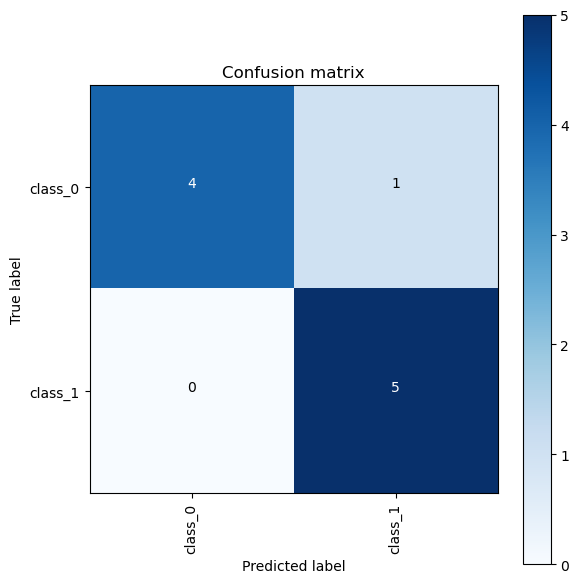

In [37]:
# validate on test set
predictions = model.predict(X_test_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_test, predictions)
print('Test Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_test, predictions) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)




# Validate on test set for the new model
predictions_new = model_new.predict(X_test_prep)
predictions_new = [1 if x > 0.5 else 0 for x in predictions_new]

accuracy_new = accuracy_score(y_test, predictions_new)
print('New Model Test Accuracy = %.2f' % accuracy_new)

confusion_mtx_new = confusion_matrix(y_test, predictions_new)

# Use list(labels.keys()) instead of list(labels.items())
cm_new = plot_confusion_matrix(confusion_mtx_new, classes=list(labels.keys()), normalize=False)

Now let's take a look at the images from the `test set` that were misclassified:

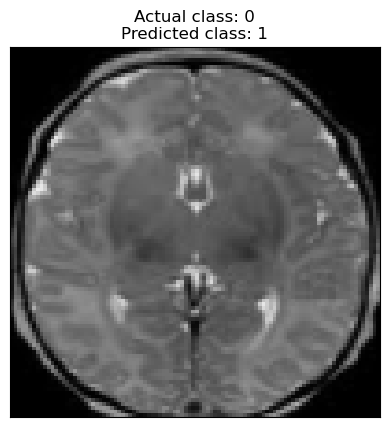

In [39]:
ind_list = np.argwhere((y_test == predictions) == False)[:, -1]
if ind_list.size == 0:
    print('There are no missclassified images.')
else:
    for i in ind_list:
        plt.figure()
        plt.imshow(X_test_crop[i])
        plt.xticks([])
        plt.yticks([])
        plt.title(f'Actual class: {y_val[i]}\nPredicted class: {predictions[i]}')
        plt.show()

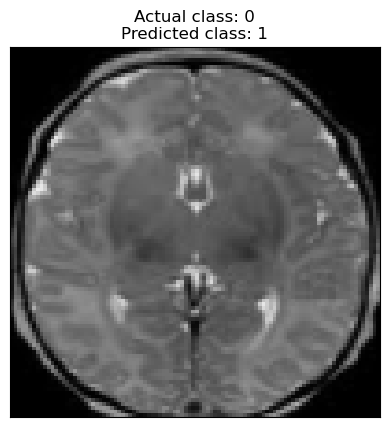

In [40]:
# For the new model
ind_list_new = np.argwhere((y_test == predictions_new) == False)[:, -1]
if ind_list_new.size == 0:
    print('There are no misclassified images for the new model.')
else:
    for i in ind_list_new:
        plt.figure()
        plt.imshow(X_test_crop[i])
        plt.xticks([])
        plt.yticks([])
        plt.title(f'Actual class: {y_test[i]}\nPredicted class: {predictions_new[i]}')
        plt.show()

# <a id='concl'>5. Conclusions</a>

<!-- This project was a combination of CNN model classification problem (to predict wheter the subject has brain tumor or not) & Computer Vision problem (to automate the process of brain cropping from MRI scans). The final accuracy is much higher than 50% baseline (random guess). However, it could be increased by larger number of train images or through model hyperparameters tuning. -->

In [41]:
# Save the model in the native Keras format
model.save('Brain_Tumor_VGG_model.h5')
model_new.save('Brain_Tumor_VGG_model_new.h5')

c:\Users\HP\anaconda3\lib\site-packages\keras\src\engine\training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



In [42]:
import tensorflow as tf
import cv2
import numpy as np

model1 = tf.keras.models.load_model(r'C:\Users\HP\Documents\GitHub\Project-Sem4\Python Models\Brain Data\Brain_Tumor_VGG_model.h5')
model2 = tf.keras.models.load_model(r'C:\Users\HP\Documents\GitHub\Project-Sem4\Python Models\Brain Data\Brain_Tumor_VGG_model_new.h5')

def preprocess_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (224, 224))  # Resize to the expected input shape
    img = img / 255.0  # Normalize pixel values to be between 0 and 1
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img

image_path = r'C:\Users\HP\Documents\GitHub\Project-Sem4\Python Models\Brain Data\Brain_tumor_dataset\no\No13.jpg'
preprocessed_img = preprocess_image(image_path)
predictions1 = model1.predict(preprocessed_img)
predictions2 = model2.predict(preprocessed_img)

class_labels = ["yes", "no"]  # Replace with your class labels
predicted_class1 = np.argmax(predictions1)
predicted_label1 = class_labels[predicted_class1]
predicted_class2 = np.argmax(predictions2)
predicted_label2 = class_labels[predicted_class2]

print("Predicted class:", predicted_label1)
print("Predicted class:", predicted_label2)

1/1 [==============================] - 0s 314ms/step
Predicted class: yes
Predicted class: yes
